# Variational Autoencoder

In [1]:
import logging

import pandas as pd

import vaep
import vaep.model
import vaep.models as models
from vaep.io import datasplits

import vaep.nb
logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info("Median Imputation")

figures = {}  # collection of ax or figures

vaep - INFO     Median Imputation


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
folder_experiment: str = 'runs/example'  # Datasplit folder with data for experiment
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'  # Metadata for samples
# model
sample_idx_position: int = 0  # position of index which is sample ID
model_key: str = 'Median'  # model key (lower cased version will be used for file names)
model: str = 'Median'  # model name
save_pred_real_na: bool = True  # Save all predictions for real na
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "Median"
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"
model_key = "Median"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/dev_dataset_small/proteinGroups_N50',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'sample_idx_position': 0,
 'model_key': 'Median',
 'model': 'Median',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070  OXCT1        30.146
2020_06_01_15_41_Q-Exactive-HF-X-Orbitrap_6070  CRELD2       24.755
2020_05_14_20_11_Q-Exactive-HF-X-Orbitrap_6070  DDX5         32.751
                                                LLPH         26.910
2020_05_26_14_20_Q-Exactive-HF-X-Orbitrap_6070  MRPS34       28.076
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError("More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = vaep.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

Gene Names
AAAS    50
AACS    41
AAMDC   34
AAMP    49
AAR2    45
Name: freq, dtype: int64

### Produce some addional fake samples

The validation fake NA is used to by all models to evaluate training performance.

In [13]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654


In [14]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,"9,327.000"
mean,27.230
std,2.888
min,19.974
25%,24.905
50%,26.929
75%,29.174
max,37.689


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939


### Add interpolation performance

In [16]:
# interpolated = vaep.pandas.interpolate(wide_df = data.train_X)
# val_pred_fake_na['interpolated'] = interpolated
# test_pred_fake_na['interpolated'] = interpolated
# del interpolated
# test_pred_fake_na

In [17]:
# Add median pred performance
args.n_params = data.train_X.shape[-1]
medians_train = data.train_X.median()
medians_train.name = args.model
pred = medians_train

val_pred_fake_na = val_pred_fake_na.join(medians_train)
test_pred_fake_na = test_pred_fake_na.join(medians_train)
val_pred_fake_na

,,observed,Median
Sample ID,Gene Names,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,28.397
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,30.188
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,30.994
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,26.171
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,32.923
...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.379
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.092
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,24.882


In [18]:
if args.save_pred_real_na:
    mask = data.train_X.isna().stack()
    idx_real_na = mask.index[mask]
    idx_real_na = (idx_real_na
                   .drop(val_pred_fake_na.index)
                   .drop(test_pred_fake_na.index))
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(medians_train)
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Median
Sample ID                                      Gene Names         
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 AAMDC        25.519
                                               ABCB7        25.970
                                               ABCC4        24.191
                                               ABI2         24.920
                                               ACOT2;ACOT1  27.107
...                                                            ...
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 ZNF346       25.135
                                               ZNF706       25.824
                                               ZNRF2        24.940
                                               ZWILCH       24.871
                                               pk;ZAK       26.939

[33698 rows x 1 columns]

### Plots


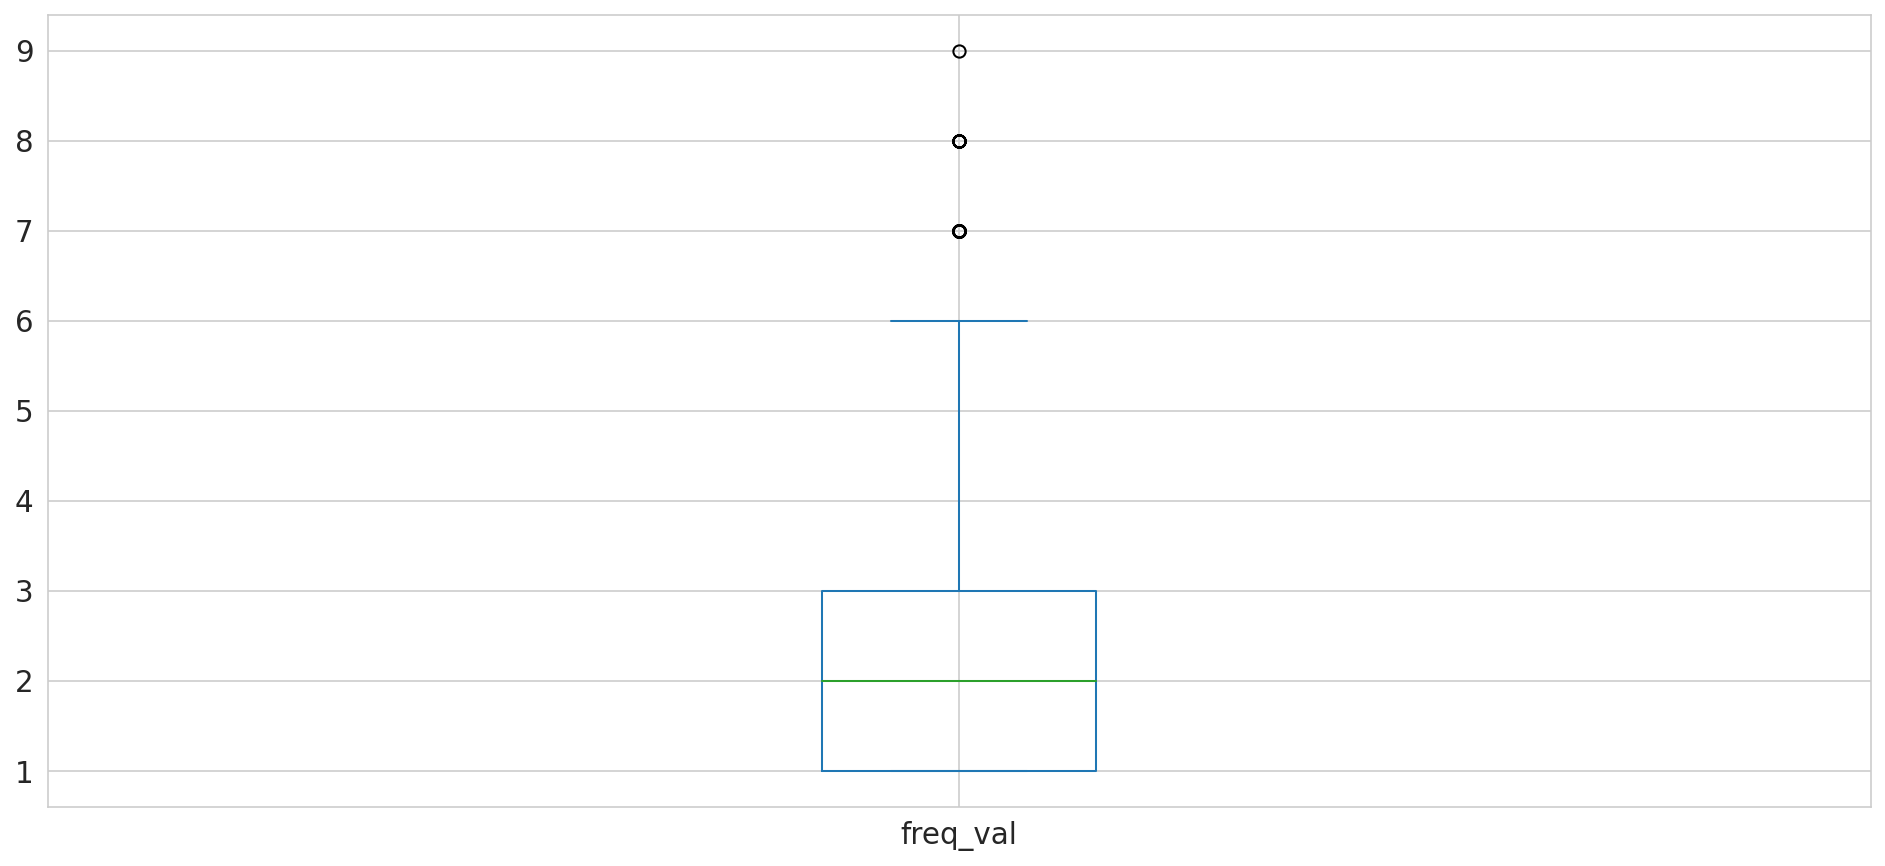

In [19]:
feat_freq_val = val_pred_fake_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [20]:
# # scatter plot between overall feature freq and split freq
# freq_feat.to_frame('overall').join(feat_freq_val).plot.scatter(x='overall', y='freq_val')

In [21]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

1   1,121
2   1,148
3     803
4     461
5     185
Name: freq_val, dtype: int64

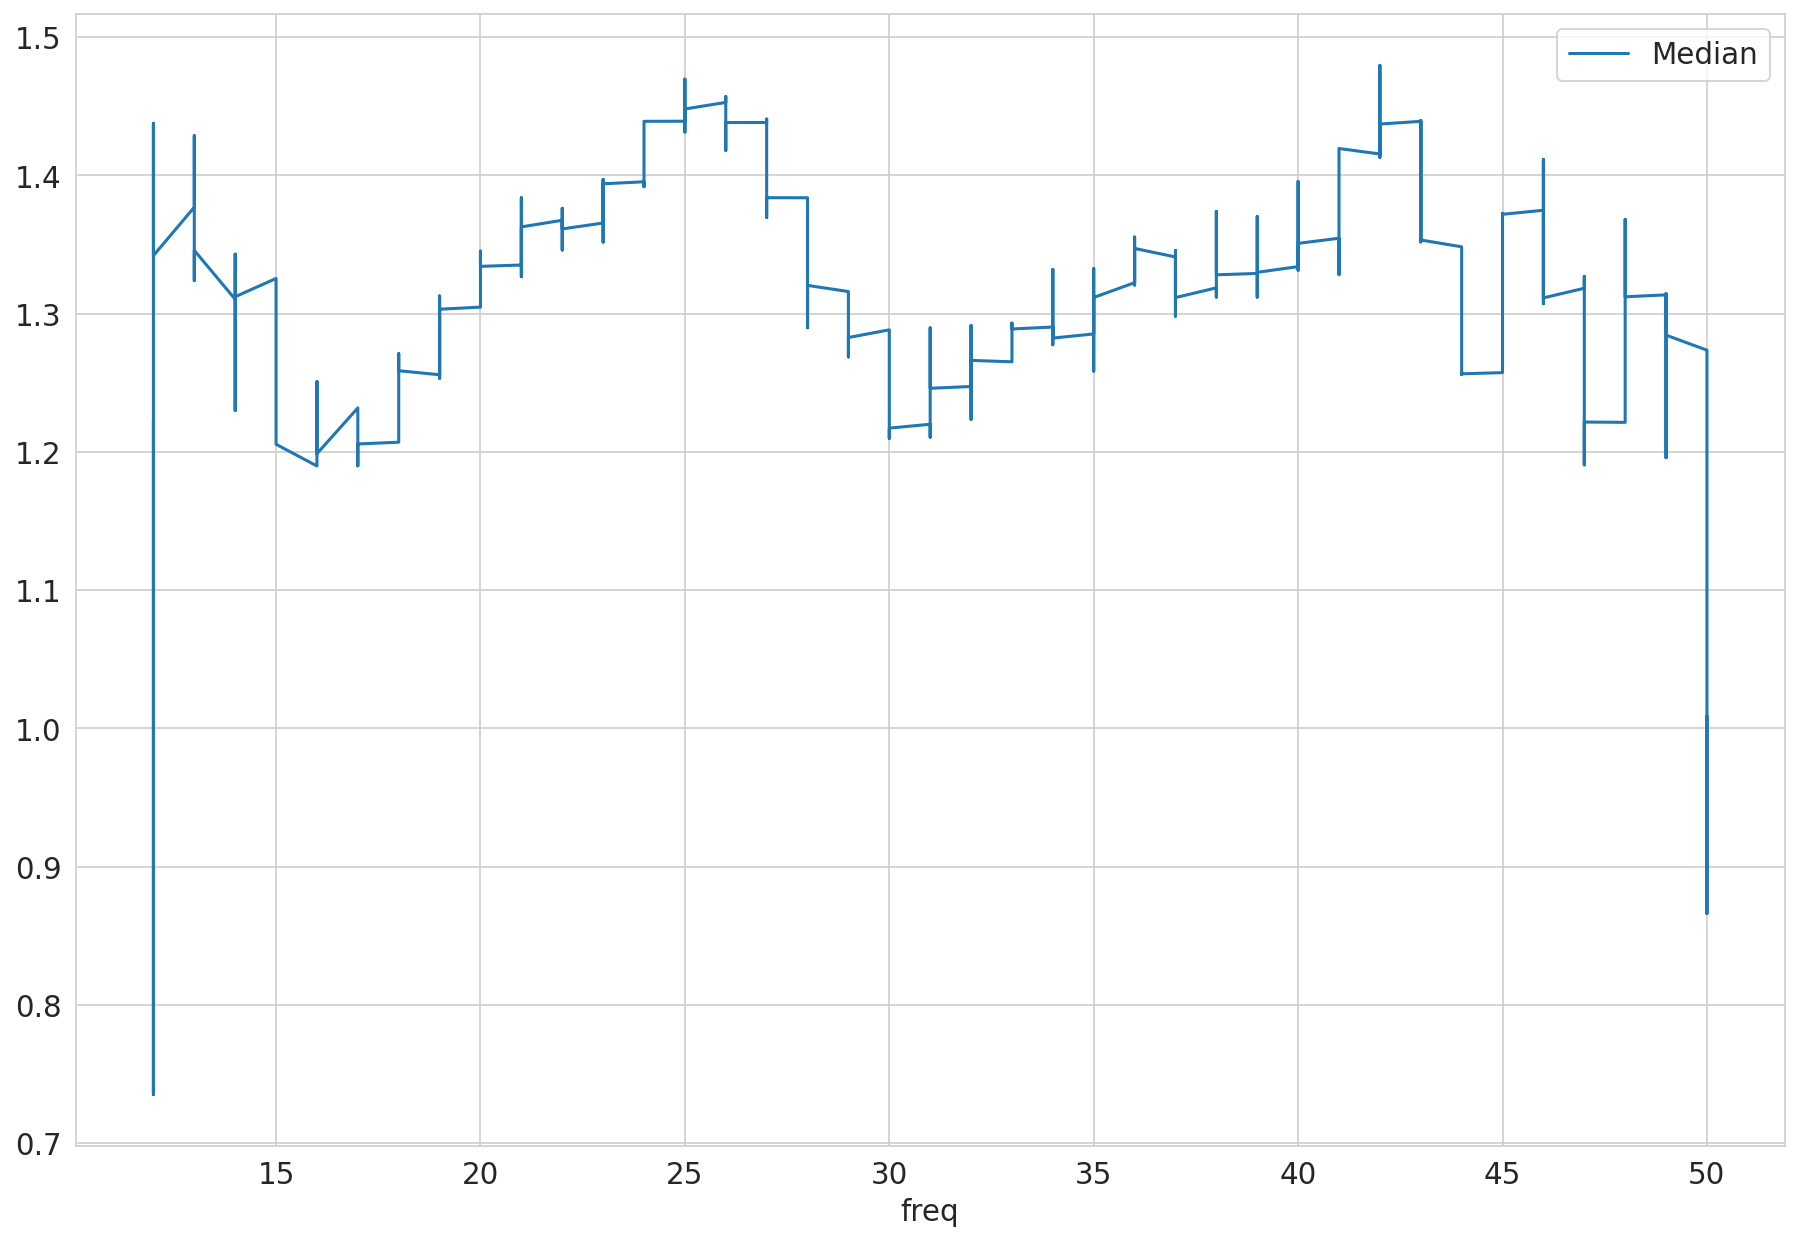

In [22]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-
                                       1]] = errors_val[errors_val.columns[:-
                                                                           1]].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [23]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

Median      
                   mean count
Gene Names                   
AAAS              2.490     2
AACS              1.218     2
AAMDC             1.229     5
AAMP              0.897     2
AAR2              1.348     2
...                 ...   ...
ZWILCH            0.082     1
ZWINT             0.659     1
ZYX               1.059     4
hCG_2014768;TMA7  0.970     1
pk;ZAK            1.348     1

[3831 rows x 2 columns]

In [24]:
errors_val

,,Median
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,1.217
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,-0.071
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,0.364
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,1.629
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,-1.011
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,-0.339
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,-0.875
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,-1.772


## Comparisons

> Note: The interpolated values have less predictions for comparisons than the ones based on models (CF, DAE, VAE)
> The comparison is therefore not 100% fair as the interpolated samples will have more common ones (especailly the sparser the data)
> Could be changed.

### Validation data

- all measured (identified, observed) peptides in validation data

> Does not make too much sense to compare collab and AEs,
> as the setup differs of training and validation data differs

In [25]:
# papermill_description=metrics
d_metrics = models.Metrics()

The fake NA for the validation step are real test data (not used for training nor early stopping)

In [26]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na, 'valid_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 2.4075508926733082,
  'MAE': 1.2118543297331748,
  'N': 9327,
  'prop': 1.0}}

### Test Datasplit

Fake NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [27]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na, 'test_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 2.427860491097487,
  'MAE': 1.210330374092836,
  'N': 9327,
  'prop': 1.0}}

The fake NA for the validation step are real test data (not used for training nor early stopping)

### Save all metrics as json

In [28]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics / f'metrics_{args.model_key}.json')
d_metrics

{ 'test_fake_na': { 'Median': { 'MAE': 1.210330374092836,
                                'MSE': 2.427860491097487,
                                'N': 9327,
                                'prop': 1.0}},
  'valid_fake_na': { 'Median': { 'MAE': 1.2118543297331748,
                                 'MSE': 2.4075508926733082,
                                 'N': 9327,
                                 'prop': 1.0}}}

In [29]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset              valid_fake_na  test_fake_na
model  metric_name                             
Median MSE                  2.408         2.428
       MAE                  1.212         1.210
       N                9,327.000     9,327.000
       prop                 1.000         1.000

## Save predictions

In [30]:
# val
fname = args.out_preds / f"pred_val_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())  # add [] assignment?
val_pred_fake_na.to_csv(fname)
# test
fname = args.out_preds / f"pred_test_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())
test_pred_fake_na.to_csv(fname)

## Config

In [31]:
figures  # switch to fnames?

{}

In [32]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 4405,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'n_params': 4405,
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'pred_test_Median': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_test_Median.csv',
 'pred_val_Median': 'runs/dev_dataset_small/proteinGroups_N50/preds/pred_val_Median.csv',
 'sample_idx_position': 0,
 'save_pred_real_na': True}